<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Training-using-all-columns-and-25%-training-sample" data-toc-modified-id="Training-using-all-columns-and-25%-training-sample-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Training using all columns and 25% training sample</a></span><ul class="toc-item"><li><span><a href="#XGBoost-with-default-parameters" data-toc-modified-id="XGBoost-with-default-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>XGBoost with default parameters</a></span></li><li><span><a href="#Random-Forest-with-default-parameters" data-toc-modified-id="Random-Forest-with-default-parameters-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Random Forest with default parameters</a></span></li><li><span><a href="#Catboost-with-default-parameters" data-toc-modified-id="Catboost-with-default-parameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Catboost with default parameters</a></span></li><li><span><a href="#K-nearest-Neighbors" data-toc-modified-id="K-nearest-Neighbors-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>K-nearest Neighbors</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Plotting-the-ROC-curves" data-toc-modified-id="Plotting-the-ROC-curves-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Plotting the ROC curves</a></span><ul class="toc-item"><li><span><a href="#Validation-Set-Performance" data-toc-modified-id="Validation-Set-Performance-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Validation Set Performance</a></span></li><li><span><a href="#Test-set-Performance" data-toc-modified-id="Test-set-Performance-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Test set Performance</a></span></li></ul></li></ul></li><li><span><a href="#Training-using-all-columns-and-undersampling-the-majority-class" data-toc-modified-id="Training-using-all-columns-and-undersampling-the-majority-class-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training using all columns and undersampling the majority class</a></span><ul class="toc-item"><li><span><a href="#XGBoost-with-default-parameters" data-toc-modified-id="XGBoost-with-default-parameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>XGBoost with default parameters</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Plotting-the-ROC-curves" data-toc-modified-id="Plotting-the-ROC-curves-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Plotting the ROC curves</a></span><ul class="toc-item"><li><span><a href="#Validation-Set-Performance" data-toc-modified-id="Validation-Set-Performance-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Validation Set Performance</a></span></li><li><span><a href="#Test-set-Performance" data-toc-modified-id="Test-set-Performance-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Test set Performance</a></span></li></ul></li></ul></li><li><span><a href="#Training-using-all-the-data-and-all-columns" data-toc-modified-id="Training-using-all-the-data-and-all-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training using all the data and all columns</a></span></li><li><span><a href="#Training-using-undersampled-data-and-continuous-columns" data-toc-modified-id="Training-using-undersampled-data-and-continuous-columns-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training using undersampled data and continuous columns</a></span></li><li><span><a href="#Oversampling-using-SMOTE" data-toc-modified-id="Oversampling-using-SMOTE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Oversampling using SMOTE</a></span></li><li><span><a href="#Balancing-positive-and-negative-weights-with-scale_pos_weight" data-toc-modified-id="Balancing-positive-and-negative-weights-with-scale_pos_weight-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Balancing positive and negative weights with <code>scale_pos_weight</code></a></span></li><li><span><a href="#Basic-For-Loop-for-Feature-Selection" data-toc-modified-id="Basic-For-Loop-for-Feature-Selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Basic For Loop for Feature Selection</a></span></li><li><span><a href="#Hyperrparameter-Tuning-for-XGBoost" data-toc-modified-id="Hyperrparameter-Tuning-for-XGBoost-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Hyperrparameter Tuning for XGBoost</a></span></li></ul></div>

In [183]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import warnings
import numpy as np
import dask.dataframe as dd
import os
import itertools
import matplotlib.ticker as ticker
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
alt.renderers.enable('default')
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')
sns.set_palette(sns.color_palette("Set3"))

In [2]:
# df = pd.read_csv('/content/drive/MyDrive/ml_projects/churn_prediction/final_masterTable.csv')
df = pd.read_csv('final_masterTable.csv')

In [3]:
df.groupby('date_pred')['is_churn'].value_counts().to_frame('count_churn')

count_churn
date_pred is_churn             
201701    0              828403
          1               39126
201702    0              929460
          1               63471
201703    0              883630
          1               87330
201704    0              907471

In [4]:
df.fillna(0, inplace=True)
df.reset_index(drop=True, inplace=True)

# Training using all columns and 25% training sample

In [5]:
sample_train = df[df.date_pred == 201701].sample(frac=0.25, random_state=0).reset_index(drop=True)

In [6]:
dfMasterTable = pd.concat([sample_train, df[df.date_pred >= 201702]])

In [7]:
dfMasterTable.groupby('date_pred')['is_churn'].value_counts().to_frame('count_churn')

count_churn
date_pred is_churn             
201701    0              207202
          1                9680
201702    0              929460
          1               63471
201703    0              883630
          1               87330
201704    0              907471

In [8]:
cont_cols = [x for x in dfMasterTable.columns if not (x.startswith('city') or x.startswith('registered') or x in ['gender', 'msno', 'is_churn', 'date_pred'])]

In [9]:
print(cont_cols)

['bd', 'tenure_days', 'actual_amount_paid_min', 'actual_amount_paid_max', 'actual_amount_paid_mean', 'actual_amount_paid_std', 'actual_amount_paid_sum', 'is_auto_renew_mean', 'is_auto_renew_sum', 'is_cancel_sum', 'is_cancel_mean', 'msno_count_x', 'diff_dates_min', 'diff_dates_max', 'diff_dates_mean', 'diff_dates_std', 'churn_mean', 'churn_sum', 'days_last_trx', 'total_secs_sum', 'total_secs_mean', 'total_secs_std', 'num_unq_sum', 'num_unq_mean', 'num_unq_std', 'msno_count_y', 'nbr_logins_monthly_mean', 'nbr_logins_monthly_max', 'nbr_logins_monthly_min', 'nbr_logins_monthly_std', 'nbr_logins_monthly_count', 'last_login_days']


In [10]:
dfMasterTable_scaled = dfMasterTable.copy()
sc = StandardScaler()
dfMasterTable_scaled[cont_cols] = sc.fit_transform(dfMasterTable_scaled[cont_cols])

In [11]:
train_df = dfMasterTable[dfMasterTable.date_pred == 201701]
validation_df = dfMasterTable[dfMasterTable.date_pred == 201702]
test_df = dfMasterTable[dfMasterTable.date_pred == 201703]

In [12]:
X_train = train_df.drop(['msno', 'is_churn', 'date_pred'], 1).values
y_train = train_df['is_churn'].values

X_val = validation_df.drop(['msno', 'is_churn', 'date_pred'], 1).values
y_val = validation_df['is_churn'].values

X_test = test_df.drop(['msno', 'is_churn', 'date_pred'], 1).values
y_test = test_df['is_churn'].values

In [13]:
train_df_scaled = dfMasterTable_scaled[dfMasterTable_scaled.date_pred == 201701]
validation_df_scaled = dfMasterTable_scaled[dfMasterTable_scaled.date_pred == 201702]
test_df_scaled = dfMasterTable_scaled[dfMasterTable_scaled.date_pred == 201703]

In [14]:
X_train_scaled = train_df_scaled.drop(['msno', 'is_churn', 'date_pred'], 1).values

X_val_scaled = validation_df_scaled.drop(['msno', 'is_churn', 'date_pred'], 1).values

X_test_scaled = test_df_scaled.drop(['msno', 'is_churn', 'date_pred'], 1).values

In [15]:
del dfMasterTable, dfMasterTable_scaled, train_df, validation_df, test_df, train_df_scaled, test_df_scaled, validation_df_scaled

## XGBoost with default parameters

In [16]:
# we will use history binning for XGBoost to speed up the training process
xgb_all_cols = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
xgb_all_cols.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [17]:
def model_predictions(model, validation=X_val, test=X_test):
    preds_val_model_all_cols = model.predict_proba(validation)[:, 1]
    preds_test_model_all_cols = model.predict_proba(test)[:, 1]
    print('validation performance : {:.2f}'.format(roc_auc_score(y_val, preds_val_model_all_cols) * 100))
    print('test performance :{:.2f}'.format(roc_auc_score(y_test, preds_test_model_all_cols) * 100))
    return preds_val_model_all_cols, preds_test_model_all_cols

In [18]:
preds_val_xgb_all_cols, preds_test_xgb_all_cols = model_predictions(xgb_all_cols)

validation performance : 69.26
test performance :65.01


In [19]:
del xgb_all_cols

## Random Forest with default parameters

In [20]:
rf_all_cols = RandomForestClassifier(n_jobs=-1, n_estimators=300, random_state=0)
rf_all_cols.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=0)

In [21]:
preds_val_rf_all_cols, preds_test_rf_all_cols = model_predictions(rf_all_cols)

validation performance : 71.75
test performance :69.45


In [22]:
del rf_all_cols

## Catboost with default parameters

In [23]:
cat_all_cols = CatBoostClassifier(random_state=0, verbose=0)
cat_all_cols.fit(X_train, y_train)

In [24]:
preds_val_cat_all_cols, preds_test_cat_all_cols = model_predictions(cat_all_cols)

validation performance : 69.93
test performance :66.82


In [25]:
del cat_all_cols

## K-nearest Neighbors

We need to use the sclaed data for the knn algorithm since the scale of the 
features is different and since the algorithm is based on distance and uses 
feature values that particular feature will dominate the distance

In [26]:
# knn_all_columns = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)
# knn_all_columns.fit(X_train_scaled, y_train)
# preds_val_knn_all_cols, preds_test_knn_all_cols = model_predictions(knn_all_columns)
# del knn_all_columns

## Logistic Regression

We need to use the scaled data for the logistic regression since it highly recommended especially when using the regularization since Regularization makes the predictor dependent on the scale of the features.

In [27]:
lr_all_cols = LogisticRegression(random_state=0, n_jobs=-1)
lr_all_cols.fit(X_train_scaled, y_train)

LogisticRegression(n_jobs=-1, random_state=0)

In [28]:
preds_val_lr_all_cols, preds_test_lr_all_cols = model_predictions(lr_all_cols)

validation performance : 49.57
test performance :46.82


In [29]:
del lr_all_cols

## Plotting the ROC curves

In [30]:
labels = ['XGBoost', 'Random Forest', 'Logistic Regression', 'CatBoost', 'No Skill']

### Validation Set Performance

In [31]:
ns_probs_val = np.random.randint(0, 2, y_val.shape[0])
ns_auc_val = roc_auc_score(y_val, ns_probs_val)
predictions_models_val = [preds_val_xgb_all_cols, preds_val_rf_all_cols, preds_val_lr_all_cols, preds_val_cat_all_cols, ns_probs_val]
predictions_val = [{'label': x , "prediction": predictions_models_val[i]} for i, x in enumerate(labels)]

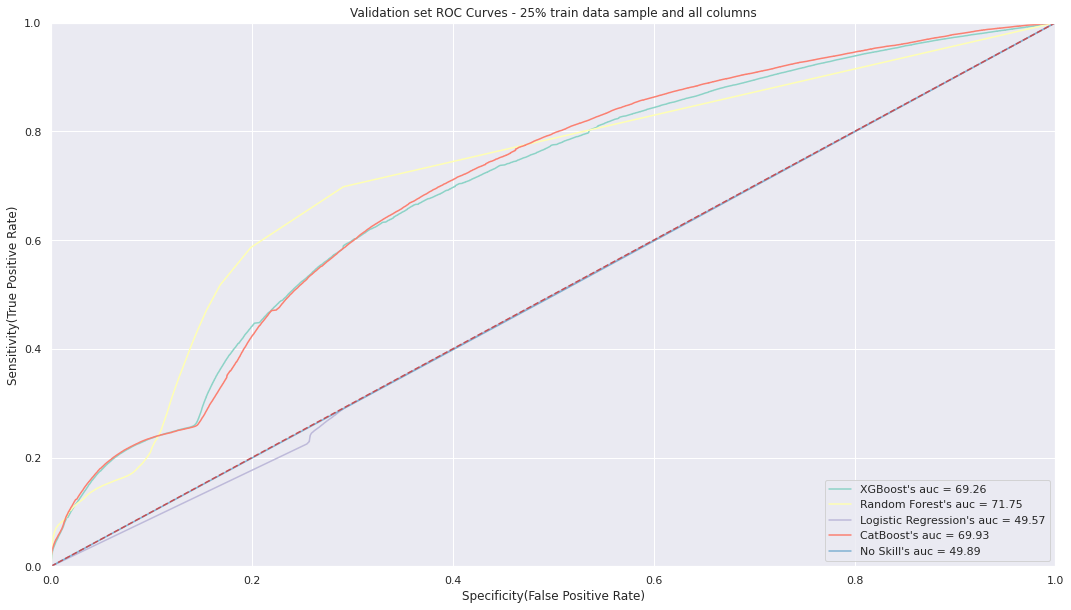

In [32]:
plt.figure(figsize=(18, 10))
for x in predictions_val:
    label, prediction = x['label'], x['prediction']
    fpr, tpr, thresholds = roc_curve(y_val, prediction)
    auc = roc_auc_score(y_val, prediction) * 100
    plt.plot(fpr, tpr, label="{}'s auc = {:.2f}".format(label, auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Validation set ROC Curves - 25% train data sample and all columns')
plt.legend(loc="lower right")
plt.show()

### Test set Performance

In [33]:
ns_probs_test = np.random.randint(0, 2, len(y_test))
ns_auc_test = roc_auc_score(y_test, ns_probs_test)
predictions_models_test = [preds_test_xgb_all_cols, preds_test_rf_all_cols, preds_test_lr_all_cols, preds_test_cat_all_cols, ns_probs_test]
predictions_test = [{'label': x , "prediction": predictions_models_test[i]} for i, x in enumerate(labels)]

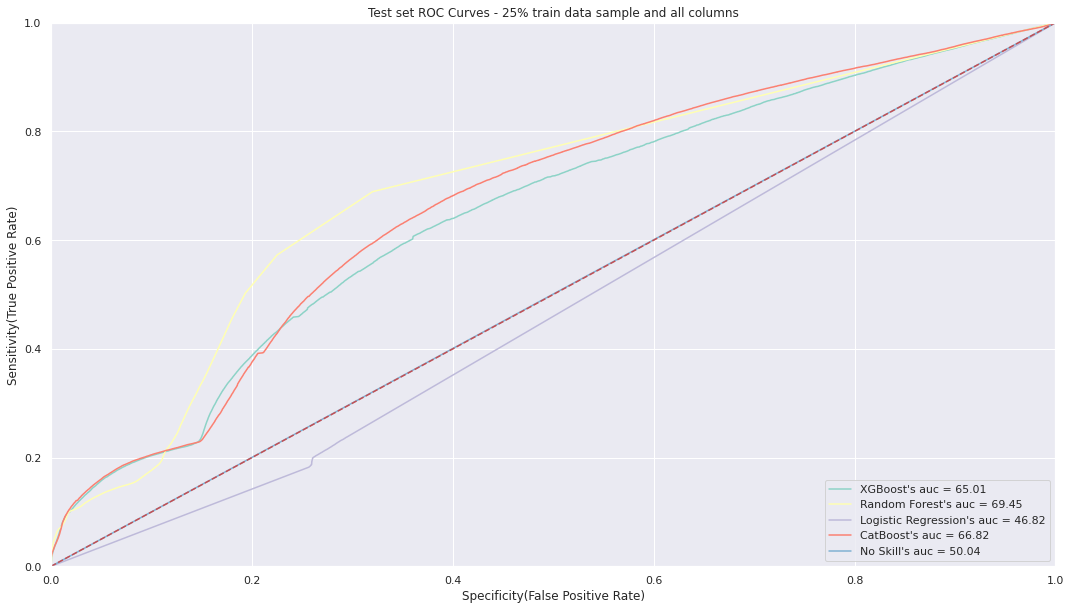

In [34]:
plt.figure(figsize=(18, 10))
for x in predictions_test:
    label, prediction = x['label'], x['prediction']
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    auc = roc_auc_score(y_test, prediction) * 100
    plt.plot(fpr, tpr, label="{}'s auc = {:.2f}".format(label, auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Test set ROC Curves - 25% train data sample and all columns')
plt.legend(loc="lower right")
plt.show()

# Training using all columns and undersampling the majority class

In [35]:
train_df_all = df[df.date_pred == 201701]
validation_df = df[df.date_pred == 201702]
test_df = df[df.date_pred == 201703]

In [36]:
X_train_all = train_df_all.drop(['msno', 'is_churn', 'date_pred'], 1).values
y_train_all = train_df_all['is_churn'].values

X_val = validation_df.drop(['msno', 'is_churn', 'date_pred'], 1).values
y_val = validation_df['is_churn'].values

X_test = test_df.drop(['msno', 'is_churn', 'date_pred'], 1).values
y_test = test_df['is_churn'].values

In [37]:
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_all, y_train_all)

In [38]:
X_train_resampled.shape

(78252, 47)

In [39]:
pd.Series(y_train_all).value_counts()

0    828403
1     39126
dtype: int64

In [40]:
pd.Series(y_train_resampled).value_counts()

0    39126
1    39126
dtype: int64

In [41]:
del train_df_all, validation_df, test_df

## XGBoost with default parameters

In [42]:
# we will use history binning for XGBoost to speed up the training process
xgb_all_cols_resampled = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
xgb_all_cols_resampled.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [43]:
preds_val_xgb_rus, preds_test_xgb_rus = model_predictions(xgb_all_cols_resampled)

validation performance : 72.41
test performance :68.56


In [44]:
del xgb_all_cols_resampled

## Random Forest 

In [45]:
rf_all_cols_rus = RandomForestClassifier(n_jobs=-1, n_estimators=300, random_state=0)
rf_all_cols_rus.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=0)

In [46]:
preds_val_rf_rus_all_cols, preds_test_rf_rus_all_cols = model_predictions(rf_all_cols_rus)

validation performance : 75.01
test performance :72.75


In [47]:
del rf_all_cols_rus

## CatBoost

In [48]:
cat_all_cols_rus = CatBoostClassifier(random_state=0, verbose=0)
cat_all_cols_rus.fit(X_train_resampled, y_train_resampled)

In [49]:
preds_val_cat_all_cols_rus, preds_test_cat_all_cols_rus = model_predictions(cat_all_cols_rus)

validation performance : 64.98
test performance :63.36


In [50]:
del cat_all_cols_rus

## Plotting the ROC curves

In [51]:
labels = ['XGBoost', 'Random Forest', 'CatBoost', 'No Skill']

### Validation Set Performance

In [52]:
ns_probs_val = np.random.randint(0, 2, len(y_val))
ns_auc_val = roc_auc_score(y_val, ns_probs_val)
predictions_models_val = [preds_val_xgb_rus, preds_val_rf_rus_all_cols, preds_val_cat_all_cols_rus, ns_probs_val]
predictions_val = [{'label': x , "prediction": predictions_models_val[i]} for i, x in enumerate(labels)]

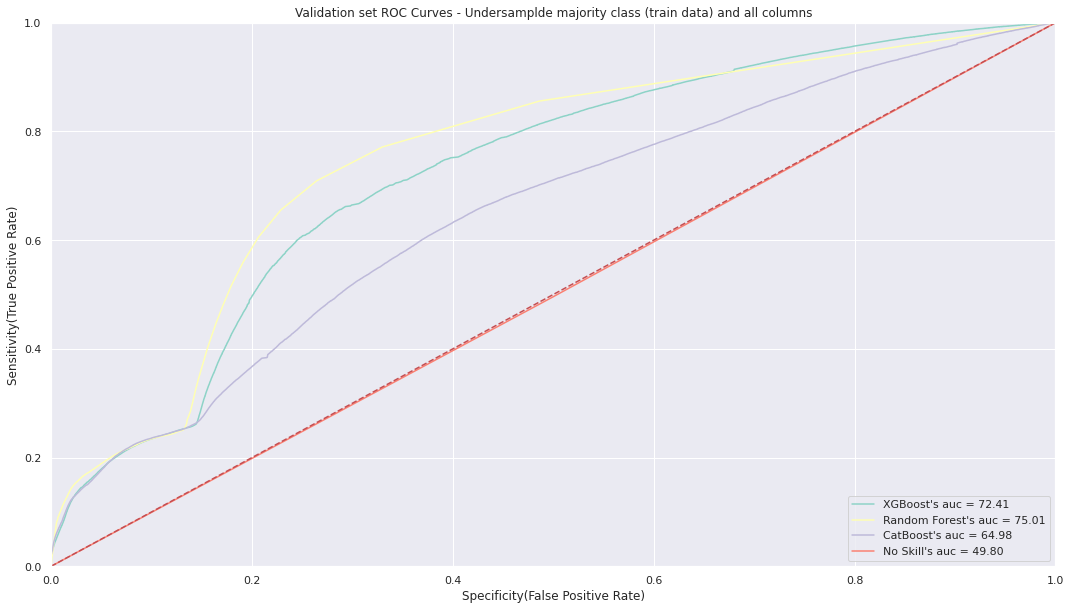

In [53]:
plt.figure(figsize=(18, 10))
for x in predictions_val:
    label, prediction = x['label'], x['prediction']
    fpr, tpr, thresholds = roc_curve(y_val, prediction)
    auc = roc_auc_score(y_val, prediction) * 100
    plt.plot(fpr, tpr, label="{}'s auc = {:.2f}".format(label, auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Validation set ROC Curves - Undersamplde majority class (train data) and all columns')
plt.legend(loc="lower right")
plt.show()

### Test set Performance

In [54]:
ns_probs_test = np.random.randint(0, 2, len(y_test))
ns_auc_test = roc_auc_score(y_test, ns_probs_test)
predictions_models_test = [preds_test_xgb_rus, preds_test_rf_rus_all_cols, preds_test_cat_all_cols_rus, ns_probs_test]
predictions_test = [{'label': x , "prediction": predictions_models_test[i]} for i, x in enumerate(labels)]

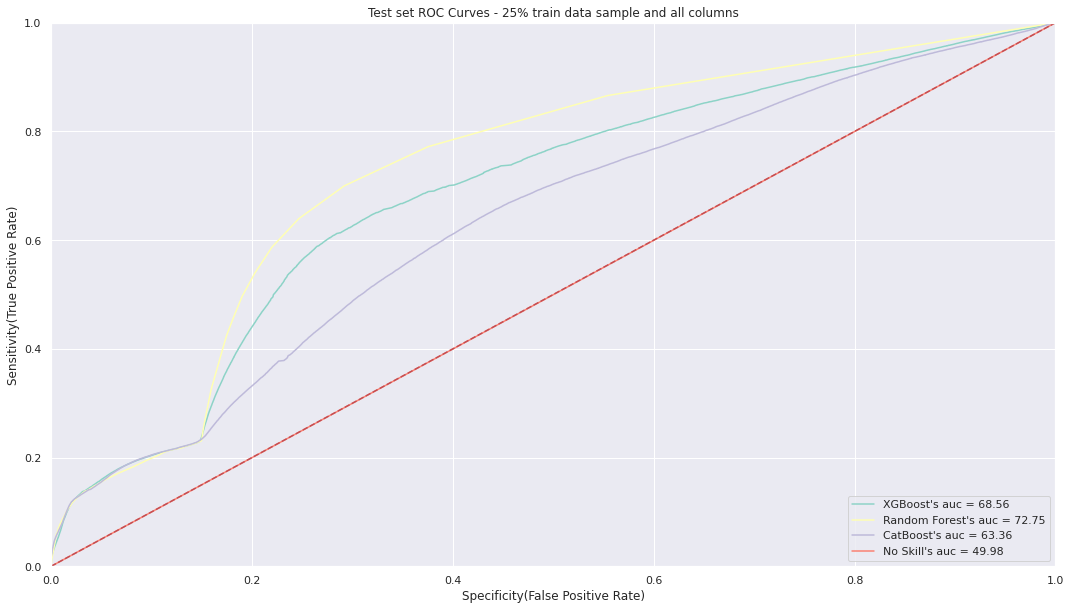

In [55]:
plt.figure(figsize=(18, 10))
for x in predictions_test:
    label, prediction = x['label'], x['prediction']
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    auc = roc_auc_score(y_test, prediction) * 100
    plt.plot(fpr, tpr, label="{}'s auc = {:.2f}".format(label, auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Test set ROC Curves - 25% train data sample and all columns')
plt.legend(loc="lower right")
plt.show()

We can see from the previous results that both of the models `XGBoost` and the `Random Forest` perform the best on the two experiments that we did : **25% training sample** and **undersampled (majority class)**.

We will use `XGBoost` for the rest of the modeling phase since it trains much faster (due to using the `tree_method="hist"`). The results obtained from the other models can be used later on by combining their predictions (averaging the probabilities) by giving larger weights to the models that perform the best, or by `stacking`them.

# Training using all the data and all columns

In [56]:
# we will use history binning for XGBoost to speed up the training process
xgb_all = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
xgb_all.fit(X_train_all, y_train_all)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [57]:
preds_val_xgb_all, preds_test_xgb_all = model_predictions(xgb_all)

validation performance : 68.75
test performance :63.54


In [58]:
del xgb_all

We can see from the previous results that the performance hasn't increased by much compared to the previous experiments where we did undersampling (**~2 to 3% increase** in `auc`) but the training has gotten much slower. Therefore, we will **keep using the undersampled data for the rest of the modeling process**.

# Training using undersampled data and continuous columns

In [59]:
train_df_all = df[df.date_pred == 201701]
validation_df = df[df.date_pred == 201702]
test_df = df[df.date_pred == 201703]

In [60]:
X_train_cont = train_df_all.drop(['msno', 'is_churn', 'date_pred'], 1)[cont_cols].values
y_train = train_df_all['is_churn'].values

X_val_cont = validation_df.drop(['msno', 'is_churn', 'date_pred'], 1)[cont_cols].values
y_val = validation_df['is_churn'].values

X_test_cont = test_df.drop(['msno', 'is_churn', 'date_pred'], 1)[cont_cols].values
y_test = test_df['is_churn'].values

In [61]:
rus = RandomUnderSampler(random_state=0)
X_train_resampled_cont, y_train_resampled_cont = rus.fit_resample(X_train_cont, y_train)

In [62]:
X_train_resampled_cont.shape

(78252, 32)

In [63]:
del train_df_all, validation_df, test_df

In [64]:
# we will use history binning for XGBoost to speed up the training process
xgb_cont_cols_resampled = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
xgb_cont_cols_resampled.fit(X_train_resampled_cont, y_train_resampled_cont)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [65]:
preds_val_xgb_cont, preds_test_xgb_cont = model_predictions(xgb_cont_cols_resampled, X_val_cont, X_test_cont)

validation performance : 72.23
test performance :67.81


In [66]:
del xgb_cont_cols_resampled

# Oversampling using SMOTE 

We can now apply `SMOTE` to generate new instances of the minority class in order to balance out the huge class imbalance that we see in the dataset. It is **only possible to apply `SMOTE` when we have continous variables** because `SMOTE` relies on computing the distances and computing them when points have mixed features (continuous and categorical) using the euclidean distance doesn't make sense.

In [67]:
pd.Series(y_train).value_counts()

0    828403
1     39126
dtype: int64

In [68]:
sm = SMOTE(random_state=0, k_neighbors=5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_cont, y_train)

In [69]:
pd.Series(y_train_smote).value_counts()

0    828403
1    828403
dtype: int64

In [70]:
# we will use history binning for XGBoost to speed up the training process
xgb_smote = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
xgb_smote.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [71]:
preds_val_xgb_smote, preds_test_xgb_smote = model_predictions(xgb_smote, X_val_cont, X_test_cont)

validation performance : 67.72
test performance :64.38


In [72]:
del xgb_smote, X_train_smote, y_train_smote

# Balancing positive and negative weights with `scale_pos_weight`

In [73]:
scale_pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()
print(scale_pos_weight)

21.172698461381177


In [74]:
# we will use history binning for XGBoost to speed up the training process
xgb_all_penalized = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0, scale_pos_weight=scale_pos_weight)
xgb_all_penalized.fit(X_train_all, y_train_all)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [75]:
preds_val_xgb_all_penalized, preds_test_xgb_all_penalized = model_predictions(xgb_all_penalized)

validation performance : 70.19
test performance :64.06


In [76]:
del xgb_all_penalized

In [77]:
import sys

ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:10]


[('df', 1843273404),
 ('sample_train', 106922967),
 ('X_train_resampled', 29422880),
 ('X_train_resampled_cont', 20032640),
 ('ns_probs_val', 7943560),
 ('ns_probs_test', 7767792),
 ('prediction', 7767792),
 ('y_train_resampled', 626128),
 ('y_train_resampled_cont', 626128),
 ('RandomForestClassifier', 2008)]

In [78]:
del sample_train, X_train_resampled, X_train_resampled_cont, ns_probs_val, ns_probs_test, prediction, y_train_resampled, y_train_resampled_cont

# Basic For Loop for Feature Selection

In [79]:
train_df = df[df.date_pred == 201701]
validation_df = df[df.date_pred == 201702]
test_df = df[df.date_pred == 201703]

In [104]:
auc_feature_selection = []

for i, column in enumerate(cont_cols):
    keep_cols = cont_cols[:i+1]
    
    X_train, y_train = train_df[keep_cols], train_df['is_churn']
    X_val, y_val = validation_df[keep_cols], validation_df['is_churn']    
    
    clf = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
    clf.fit(X_train, y_train, verbose=False)
    
    preds = clf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, preds)
    auc_feature_selection.append((column, auc))
    print(auc_feature_selection[i])

('bd', 0.5963032636918917)
('tenure_days', 0.624654764461558)
('actual_amount_paid_min', 0.7558299273991331)
('actual_amount_paid_max', 0.7744721398027364)
('actual_amount_paid_mean', 0.7749386148930597)
('actual_amount_paid_std', 0.7742643126460682)
('actual_amount_paid_sum', 0.7762783321244138)
('is_auto_renew_mean', 0.7941068822265926)
('is_auto_renew_sum', 0.7953513492583767)
('is_cancel_sum', 0.8220235626629369)
('is_cancel_mean', 0.8246194248738901)
('msno_count_x', 0.8242663590321417)
('diff_dates_min', 0.8004069610966686)
('diff_dates_max', 0.8122154083756464)
('diff_dates_mean', 0.7802787242313367)
('diff_dates_std', 0.8105131913125599)
('churn_mean', 0.6417777434480427)
('churn_sum', 0.6077585675192119)
('days_last_trx', 0.6529901807238152)
('total_secs_sum', 0.6318396409075137)
('total_secs_mean', 0.6361109616291888)
('total_secs_std', 0.664033764043969)
('num_unq_sum', 0.6544866838115116)
('num_unq_mean', 0.6379194504396807)
('num_unq_std', 0.67587187199602)
('msno_count_y'

We can see here that there is a huge dip in performance after adding the two variables `churn_mean` and `churn_sum`, this might be due to the fact that they are highly correlated with `is_cancel_mean` and `is_cancel_sum`. There is no need to actually check or remove correlated variables since we will only keep the variables that will increase the performance after getting added to the model.

In [105]:
city_columns = [x for x in train_df.columns if x.startswith('city')]
registration_columns = [x for x in train_df.columns if x.startswith('registered')]

categ_columns = [city_columns, registration_columns]

auc_copy = auc_feature_selection.copy()

auc_feature_selection = auc_copy

keep_cols = list(cont_cols)

In [112]:
for i, categ_feature in enumerate(categ_columns):
    keep_cols += categ_feature
    
    X_train, y_train = train_df[keep_cols], train_df['is_churn']
    X_val, y_val = validation_df[keep_cols], validation_df['is_churn']
    
    clf = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, preds)
    auc_feature_selection.append((categ_feature, auc))
    print(auc_feature_selection[-1])
    

(['city_1', 'city_4', 'city_5', 'city_13', 'city_15', 'city_22', 'city_other'], 0.7008727448765381)
(['registered_via_3', 'registered_via_4', 'registered_via_7', 'registered_via_9', 'registered_via_11', 'registered_via_13', 'registered_via_other'], 0.6994829462006826)


In [113]:
print(auc_feature_selection)

[('bd', 0.5963032636918917), ('tenure_days', 0.624654764461558), ('actual_amount_paid_min', 0.7558299273991331), ('actual_amount_paid_max', 0.7744721398027364), ('actual_amount_paid_mean', 0.7749386148930597), ('actual_amount_paid_std', 0.7742643126460682), ('actual_amount_paid_sum', 0.7762783321244138), ('is_auto_renew_mean', 0.7941068822265926), ('is_auto_renew_sum', 0.7953513492583767), ('is_cancel_sum', 0.8220235626629369), ('is_cancel_mean', 0.8246194248738901), ('msno_count_x', 0.8242663590321417), ('diff_dates_min', 0.8004069610966686), ('diff_dates_max', 0.8122154083756464), ('diff_dates_mean', 0.7802787242313367), ('diff_dates_std', 0.8105131913125599), ('churn_mean', 0.6417777434480427), ('churn_sum', 0.6077585675192119), ('days_last_trx', 0.6529901807238152), ('total_secs_sum', 0.6318396409075137), ('total_secs_mean', 0.6361109616291888), ('total_secs_std', 0.664033764043969), ('num_unq_sum', 0.6544866838115116), ('num_unq_mean', 0.6379194504396807), ('num_unq_std', 0.675871

In [114]:
final_auc = [x[1] for x in auc_feature_selection]

In [115]:
keep_features = [True] + [True if final_auc[i] > final_auc[i-1] else False for i in range(1, len(final_auc))] 

In [116]:
print(keep_features)

[True, True, True, True, True, False, True, True, True, True, True, False, False, True, False, True, False, False, True, False, True, True, False, False, True, False, False, True, True, True, False, True, False, False]


In [85]:
result_feature_selection = list(zip(auc_feature_selection, keep_features))

result_continous = result_feature_selection[:-2]

final_keep_cols = [x[0][0][-1] for x in result_continous if x[1] ]

/home/achraf/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [117]:
result_feature_selection = list(zip(auc_feature_selection, keep_features))

In [164]:
keep_columns = [x[0][0] for x in result_feature_selection if x[1]]

In [167]:
res_feature_selection = [keep_columns[0]]

for x in test[1:]:
    if type(x) == list:
        print([x])
        res_feature_selection += x
    else:
        res_feature_selection += [x]

In [170]:
print(res_feature_selection)

['bd', 'tenure_days', 'actual_amount_paid_min', 'actual_amount_paid_max', 'actual_amount_paid_mean', 'actual_amount_paid_sum', 'is_auto_renew_mean', 'is_auto_renew_sum', 'is_cancel_sum', 'is_cancel_mean', 'diff_dates_max', 'diff_dates_std', 'days_last_trx', 'total_secs_mean', 'total_secs_std', 'num_unq_std', 'nbr_logins_monthly_max', 'nbr_logins_monthly_min', 'nbr_logins_monthly_std', 'last_login_days']


In [171]:
X_train, y_train = train_df[res_feature_selection], train_df['is_churn']
X_val, y_val = validation_df[res_feature_selection], validation_df['is_churn']
X_test, y_test = test_df[res_feature_selection], test_df['is_churn']

xgb_feat_selec = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
xgb_feat_selec.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [178]:
preds_val_xgb_fs, preds_test_xgb_fs = model_predictions(xgb_feat_selec, X_val, X_test)

validation performance : 83.64
test performance :78.62


In [179]:
sm = SMOTE(random_state=0, k_neighbors=5)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [181]:
xgb_fs_res = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
xgb_fs_res.fit(X_res, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [182]:
preds_val_xgb_fs_res, preds_test_xgb_fs_res = model_predictions(xgb_fs_res, X_val, X_test)

validation performance : 81.82
test performance :76.24


In [193]:
del X_res, y_res

# Hyperrparameter Tuning for XGBoost

In [194]:
best_auc = 0
best_model = xgb_fs_res
best_params = {}

In [195]:
def objective(space):
    # Instantiate the classifier
    clf = XGBClassifier(
                 learning_rate =0.1,
                 n_estimators=150,
                 max_depth=int(space['max_depth']),
                 min_child_weight=space['min_child_weight'],
                 gamma=space['gamma'],
                 subsample=space['subsample'],
                 colsample_bytree=space['colsample_bytree'],
                 objective= 'binary:logistic',
        n_jobs=-1,
        tree_method='hist',
                 seed=0)
    
    # Fit the classsifier
    clf.fit(X_train, y_train)
    
    # Predict on Validation data
    pred = clf.predict_proba(X_val)[:,1]
    
    # Calculate our Metric : loss = - AUC
    auc = roc_auc_score(y_val, pred)
    print(auc)
    global best_auc
    global best_model
    global best_params
    if auc >  best_auc:
        best_auc = auc
        best_model = clf
        best_params = space
    # return needs to be in this below format. We use negative of auc since we want to maximize it.
    return {'loss': - auc, 'status': STATUS_OK }


In [196]:
space ={'max_depth': hp.quniform("max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'gamma' : hp.uniform ('gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('colsample_bytree', 0.7,1),
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)
print(best)

0.8382353775965719                                                                                                                                                                            
0.8454552329055769                                                                                                                                                                            
0.8394514587173173                                                                                                                                                                            
0.8441027557813905                                                                                                                                                                            
0.8370043413082815                                                                                                                                                                            
0.8391355754633778                           

In [203]:
xgb_fs_hyp = XGBClassifier(
             learning_rate =0.1,
             n_estimators=150,
             max_depth=int(best['max_depth']),
             min_child_weight=best['min_child_weight'],
             gamma=best['gamma'],
             subsample=best['subsample'],
             colsample_bytree=best['colsample_bytree'],
             objective= 'binary:logistic',
    n_jobs=-1,
    tree_method='hist',
             seed=0)

In [204]:
xgb_fs_hyp.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8328106247297329, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.1349603744889184, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=7.0,
              missing=nan, monotone_constraints='()', n_estimators=250,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [205]:
preds_val_xgb_fs_hyp, preds_test_xgb_fs_hyp = model_predictions(xgb_fs_hyp, X_val, X_test)

validation performance : 84.49
test performance :79.12


In [210]:
rf_fs_hyp = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0, verbose=1)

In [211]:
rf_fs_hyp.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestClassifier(n_jobs=-1, random_state=0, verbose=1)

In [212]:
preds_val_rf_fs_hyp, preds_test_rf_fs_hyp = model_predictions(rf_fs_hyp, X_val, X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.9s finished


validation performance : 81.74
test performance :78.06


In [204]:
xgb_fs_hyp.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8328106247297329, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.1349603744889184, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=7.0,
              missing=nan, monotone_constraints='()', n_estimators=250,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [205]:
preds_val_xgb_fs_hyp, preds_test_xgb_fs_hyp = model_predictions(xgb_fs_hyp, X_val, X_test)

validation performance : 84.49
test performance :79.12


In [221]:
xgb_fs_hyp_no_hist = XGBClassifier(
             learning_rate =0.1,
             n_estimators=150,
             max_depth=int(best['max_depth']),
             min_child_weight=best['min_child_weight'],
             gamma=best['gamma'],
             subsample=best['subsample'],
             colsample_bytree=best['colsample_bytree'],
             objective= 'binary:logistic',
    n_jobs=-1,
             seed=0)

In [ ]:
xgb_fs_hyp_no_hist.fit(X_train, y_train, verbose=2)

preds_val_xgb_fs_hyp_no_hist, preds_test_xgb_fs_hyp_no_hist = model_predictions(xgb_fs_hyp_no_hist, X_val, X_test)